Import Necesarry Library

In [1]:
# Import Necessary Libraries
import os
import json
import logging
from pathlib import Path
from collections import Counter
from multiprocessing import cpu_count

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from xgboost import XGBClassifier

import pygad

Data Preprocessing

In [2]:
# Load Data
data_path = "C:/Users/User/OneDrive - UNIVERSITAS INDONESIA/Perkuliahan/Semester 9/Tesis/Data Processing/Data/fs_data_clean.xlsx"
fs_data = pd.read_excel(data_path)

In [3]:
# Initial Data Inspection
print("First 5 rows of the dataset:")
print(fs_data.head())
print("\nDataset Information:")
print(fs_data.info())

First 5 rows of the dataset:
   kode                    nama  tahun mata_uang   kurs tanggal_listing  \
0  ADMG  Polychem Indonesia Tbk   2018       USD  14568     20 Okt 1993   
1  ADMG  Polychem Indonesia Tbk   2019       USD  13880     20 Okt 1993   
2  ADMG  Polychem Indonesia Tbk   2020       USD  14034     20 Okt 1993   
3  ADMG  Polychem Indonesia Tbk   2021       USD  14262     20 Okt 1993   
4  ADMG  Polychem Indonesia Tbk   2022       USD  15592     20 Okt 1993   

           sektor  tahun_listing  total_pendapatan  laba_sebelum_pajak  ...  \
0  Basic Material           1993       356636089.0            -1395757  ...   
1  Basic Material           1993       233390689.0           -29748345  ...   
2  Basic Material           1993       152712749.0           -34690549  ...   
3  Basic Material           1993       190192551.0              457690  ...   
4  Basic Material           1993       142773920.0           -26638933  ...   

        dar       opm         eps     book_va

In [43]:
# Separate numeric and non-numeric columns
numeric_cols = fs_data.select_dtypes(include=["float64", "int64"]).columns
non_numeric_cols = fs_data.select_dtypes(exclude=["float64", "int64"]).columns

# Handle missing values for numeric columns
imputer = SimpleImputer(strategy="median")
fs_data_numeric = pd.DataFrame(imputer.fit_transform(fs_data[numeric_cols]), columns=numeric_cols)

# Handle non-numeric columns
# If they are not required, you can drop them. Otherwise, process them as needed.
fs_data_non_numeric = fs_data[non_numeric_cols].copy()

# Combine numeric and non-numeric parts
fs_data_imputed = pd.concat([fs_data_numeric, fs_data_non_numeric.reset_index(drop=True)], axis=1)

# Verify the result
print("\nAfter Imputation and Handling Non-Numeric Data:")
print(fs_data_imputed.info())


After Imputation and Handling Non-Numeric Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tahun                           3453 non-null   float64
 1   kurs                            3453 non-null   float64
 2   tahun_listing                   3453 non-null   float64
 3   total_pendapatan                3453 non-null   float64
 4   laba_sebelum_pajak              3453 non-null   float64
 5   laba_bersih_tahun_berjalan      3453 non-null   float64
 6   laba_bersih_tahun_berjalan_idr  3453 non-null   float64
 7   aset                            3453 non-null   float64
 8   aset_t-1                        3453 non-null   float64
 9   ekuitas                         3453 non-null   float64
 10  liabilitas                      3453 non-null   float64
 11  close                           3453 non-null 

In [44]:
# Feature Engineering
fs_data_imputed['tahun'] = fs_data_imputed['tahun'].astype(int)
fs_data_imputed['kode'] = fs_data_imputed['kode'].astype(str)

# Combine 'kode' and 'tahun' to create the 'emiten' column
fs_data_imputed['emiten'] = fs_data_imputed['kode'] + " " + fs_data_imputed['tahun'].astype(str)

# Verify the 'emiten' column
print(fs_data_imputed[['kode', 'tahun', 'emiten']].head())

   kode  tahun     emiten
0  ADMG   2018  ADMG 2018
1  ADMG   2019  ADMG 2019
2  ADMG   2020  ADMG 2020
3  ADMG   2021  ADMG 2021
4  ADMG   2022  ADMG 2022


In [45]:
# Drop Unnecessary Columns
columns_to_drop = [
    'nama', 'kode', 'tahun', "mata_uang", "kurs", "tanggal_listing",
    "sektor", "tahun_listing", 'total_pendapatan','laba_sebelum_pajak',
    'laba_bersih_tahun_berjalan', 'laba_bersih_tahun_berjalan_idr',
    'aset_t-1', 'close', 'adj_price', 'share_outstanding', 'market_cap',
    'cce', 'dar','laba_kotor', 'laba_operasional', 'aset_lancar',
    'liabilitas_jangka_pendek','ato', 'cash_ratio', 'current_ratio',
    'gpm', 'aset', 'ekuitas', 'liabilitas'
]
fs_data_processed = fs_data_imputed.drop(columns=columns_to_drop)

print("\nData after dropping unnecessary columns:")
print(fs_data_processed.head())


Data after dropping unnecessary columns:
   jumlah_laba_komprehensif         per       roa       roe  \
0                 3535093.0  -64.256441 -0.004648 -0.005352   
1               -35929101.0   -1.761263 -0.115939 -0.142385   
2               -40371700.0   -1.676681 -0.187963 -0.230968   
3                 3153363.0  154.786791  0.001747  0.002071   
4               -26606591.0   -1.408219 -0.155501 -0.184124   

   net_profit_margin       opm         eps    book_value       pbv  \
0          -0.003658  0.017132   -4.886670  3.551328e+12  0.343872   
1          -0.126787 -0.116552 -105.606019  2.884588e+12  0.250777   
2          -0.253260 -0.165459 -139.561468  2.350017e+12  0.387260   
3           0.001871 -0.032007    1.305021  2.451197e+12  0.320502   
4          -0.187333 -0.109663 -107.227659  2.264933e+12  0.259286   

       aset_idr  liabilitas_idr   ekuitas_idr  total_pendapatan_idr       der  \
0  4.088944e+12    5.376159e+11  3.551328e+12          5.195475e+12  0.151384

In [46]:
# Label Encoding
fraudulent_emitens = [
    'GIAA 2018', 'ENVY 2019', 'WSKT 2018', 'WSKT 2019', 'WSKT 2020', 
    'WSKT 2021', 'WSKT 2022', 'WIKA 2018', 'WIKA 2019', 'WIKA 2020', 
    'WIKA 2021', 'WIKA 2022', 'MYRX 2018', 'ZYRX 2021', 'ZYRX 2022', 
    'TRAM 2018', 'AISA 2018', 'INAF 2020', 'INAF 2021', 'INAF 2022',
    'GIAA 2019', 'PGAS 2018', 'PGAS 2019', 'PGAS 2020', 'PGAS 2021',
    'PGAS 2022', 'MERK 2018'
]
fs_data_processed['emiten'] = fs_data_processed['emiten'].apply(lambda x: 1 if x in fraudulent_emitens else 0)


In [47]:
# Check Class Distribution
class_counts = fs_data_processed['emiten'].value_counts()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
emiten
0    3426
1      27
Name: count, dtype: int64


In [49]:
# Features and Target
X = fs_data_processed.drop(columns=['emiten'])
y = fs_data_processed['emiten']

In [50]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

print(f"\nTraining Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")
print(f"Training Labels Distribution:\n{Counter(y_train)}")
print(f"\nTest Labels Distribution:\n{Counter(y_test)}")


Training Set Shape: (2071, 14)
Test Set Shape: (1382, 14)
Training Labels Distribution:
Counter({0: 2055, 1: 16})

Test Labels Distribution:
Counter({0: 1371, 1: 11})


In [51]:
# Feature Scaling
scaler = MinMaxScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for better interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

Handling Class Imbalance

In [1]:
# Visualize Class Distribution Before Resampling
print("\nBefore Resampling:")
print(Counter(y_train))
sns.countplot(x=y_train, hue=y, palette=['#146c94', '#ff5733'])
plt.title('Training Set Class Distribution Before Resampling')
plt.xlabel('Emiten (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()


Before Resampling:


NameError: name 'Counter' is not defined

In [59]:
# Define Resampling Strategy
over = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
resampling_pipeline = ImbPipeline(steps=[('over', over), ('under', under)])

# Apply Resampling
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train_scaled, y_train)


After Resampling:
Counter({0: 822, 1: 411})


C:\Users\User\AppData\Local\Temp\ipykernel_37328\148845129.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette=['#146c94', '#ff5733'])


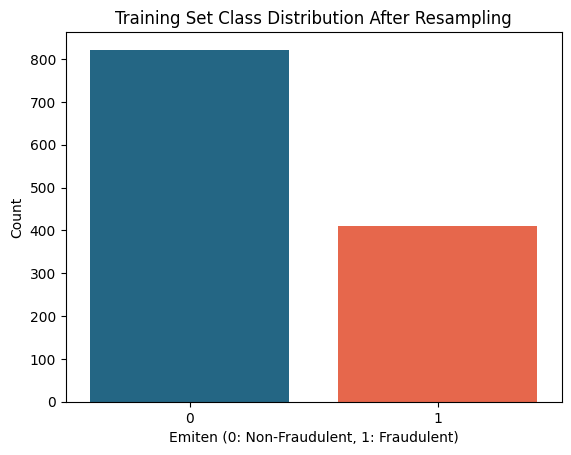

In [61]:
# Visualize Class Distribution After Resampling
print("\nAfter Resampling:")
print(Counter(y_resampled))
sns.countplot(x=y_resampled, palette=['#146c94', '#ff5733'])
plt.title('Training Set Class Distribution After Resampling')
plt.xlabel('Emiten (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()

Hyperparameter Tuning

In [63]:
# Initialize XGBoost Classifier
xgb_clf_random = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [67]:
def fitness_func(ga_instance, solution, solution_idx):
    """
    Fitness function to evaluate the XGBClassifier with given hyperparameters.
    
    Parameters:
    - ga_instance: Instance of the pygad.GA class.
    - solution: List of hyperparameter values.
    - solution_idx: Index of the solution.
    
    Returns:
    - Fitness score (float).
    """
    # Decode the solution to hyperparameters
    hyperparams = {
        'learning_rate': solution[0],
        'n_estimators': int(solution[1]),
        'max_depth': int(solution[2]),
        'min_child_weight': int(solution[3]),
        'subsample': solution[4],
        'colsample_bytree': solution[5],
        'gamma': solution[6],
        'reg_alpha': solution[7],
        'reg_lambda': solution[8],
        'scale_pos_weight': int(solution[9])
    }
    
    # Initialize the XGBoost classifier with the given hyperparameters
    model = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        **hyperparams
    )
    
    # Perform cross-validation
    scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1')
    
    # The fitness function is the mean F1-Score
    return scores.mean()


In [68]:
# Define gene space for each hyperparameter
gene_space = [
    {'low': 0.01, 'high': 0.2},     # learning_rate
    {'low': 100, 'high': 500},      # n_estimators
    {'low': 3, 'high': 8},          # max_depth
    {'low': 1, 'high': 5},          # min_child_weight
    {'low': 0.6, 'high': 1.0},      # subsample
    {'low': 0.6, 'high': 1.0},      # colsample_bytree
    {'low': 0, 'high': 0.4},        # gamma
    {'low': 0, 'high': 1.0},        # reg_alpha
    {'low': 0, 'high': 1.0},        # reg_lambda
    {'low': 1, 'high': 5}           # scale_pos_weight
]


In [69]:
# Initialize the GA instance
ga_instance = pygad.GA(
    num_generations=50,              # Number of generations
    num_parents_mating=10,           # Number of parents to mate
    fitness_func=fitness_func,        # Fitness function
    sol_per_pop=20,                   # Population size
    num_genes=10,                     # Number of hyperparameters
    gene_space=gene_space,            # Gene space
    mutation_percent_genes=10,        # Percentage of genes to mutate
    crossover_type="uniform",         # Crossover type
    mutation_type="random",           # Mutation type
    random_mutation_min_val=-0.1,     # Min mutation value
    random_mutation_max_val=0.1,      # Max mutation value
    gene_type=float,                  # Gene type
    on_generation=lambda ga: print(f"Generation {ga.generations_completed}: Best Fitness = {ga.best_solution()[1]:.4f}"),
    parallel_processing=None,         # Use parallel processing if desired
    suppress_warnings=True,           # Suppress warnings
    stop_criteria=["saturate_10"]     # Stop if no improvement over 10 generations
)

# Run the GA
print("\nStarting PyGAD Hyperparameter Tuning...")
ga_instance.run()

# Retrieve the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("\nBest Solution: ", solution)
print("Best Solution Fitness (F1-Score): ", solution_fitness)



Starting PyGAD Hyperparameter Tuning...
Generation 1: Best Fitness = 0.9680
Generation 2: Best Fitness = 0.9714
Generation 3: Best Fitness = 0.9714
Generation 4: Best Fitness = 0.9716
Generation 5: Best Fitness = 0.9727
Generation 6: Best Fitness = 0.9727
Generation 7: Best Fitness = 0.9727
Generation 8: Best Fitness = 0.9727
Generation 9: Best Fitness = 0.9738
Generation 10: Best Fitness = 0.9738
Generation 11: Best Fitness = 0.9738
Generation 12: Best Fitness = 0.9738
Generation 13: Best Fitness = 0.9738
Generation 14: Best Fitness = 0.9739
Generation 15: Best Fitness = 0.9739
Generation 16: Best Fitness = 0.9740
Generation 17: Best Fitness = 0.9740
Generation 18: Best Fitness = 0.9740
Generation 19: Best Fitness = 0.9740
Generation 20: Best Fitness = 0.9740
Generation 21: Best Fitness = 0.9740
Generation 22: Best Fitness = 0.9740
Generation 23: Best Fitness = 0.9740
Generation 24: Best Fitness = 0.9740
Generation 25: Best Fitness = 0.9740
Generation 26: Best Fitness = 0.9740
Genera

In [70]:
# Decode the best solution into hyperparameters
best_hyperparams = {
    'learning_rate': solution[0],
    'n_estimators': int(solution[1]),
    'max_depth': int(solution[2]),
    'min_child_weight': int(solution[3]),
    'subsample': solution[4],
    'colsample_bytree': solution[5],
    'gamma': solution[6],
    'reg_alpha': solution[7],
    'reg_lambda': solution[8],
    'scale_pos_weight': int(solution[9])
}

print("\nBest Hyperparameters from PyGAD:")
print(best_hyperparams)


Best Hyperparameters from PyGAD:
{'learning_rate': 0.03969911477329781, 'n_estimators': 460, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7227041272014486, 'colsample_bytree': 0.733718063197388, 'gamma': 0.029612145698581185, 'reg_alpha': 0.13685225328244055, 'reg_lambda': 0.7869096085058539, 'scale_pos_weight': 2}


In [71]:
# Initialize and train the best model from PyGAD
best_model_pygad = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **best_hyperparams
)

best_model_pygad.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.733718063197388, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.029612145698581185, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03969911477329781, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=460, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Model Evaluation

In [78]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates the model on the test set and prints performance metrics.
    
    Parameters:
    - model: Trained machine learning model.
    - X_test: Scaled test features.
    - y_test: True labels for the test set.
    - model_name: Name of the model for display purposes.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall (Sensitivity): {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


=== PyGAD XGBClassifier Evaluation ===
Accuracy: 97.25%
Precision: 11.43%
Recall (Sensitivity): 36.36%
F1-Score: 17.39%
ROC-AUC: 0.85

Confusion Matrix:
[[1340   31]
 [   7    4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1371
           1       0.11      0.36      0.17        11

    accuracy                           0.97      1382
   macro avg       0.55      0.67      0.58      1382
weighted avg       0.99      0.97      0.98      1382



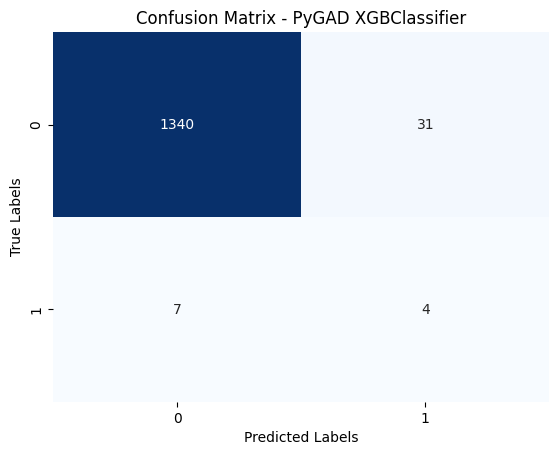

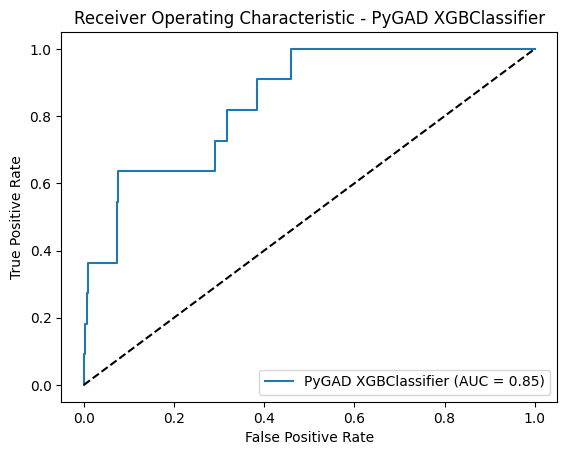

In [79]:
# Evaluate PyGAD-tuned Model
evaluate_model(best_model_pygad, X_test_scaled, y_test, model_name="PyGAD XGBClassifier")

In [80]:
# Define a function to collect metrics
def collect_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }


In [ ]:
# Collect model metrics
metrics_pygad = collect_metrics(best_model_pygad, X_test_scaled, y_test)

# Create a DataFrame for comparison
eval_df = pd.DataFrame([metrics_pygad], 
                             index=['PyGAD XGB'])
print("\n=== Model Performance ===")
print(eval_df)


=== Model Performance ===
           Accuracy  Precision    Recall  F1-Score  ROC-AUC
PyGAD XGB  0.972504   0.114286  0.363636  0.173913   0.8457


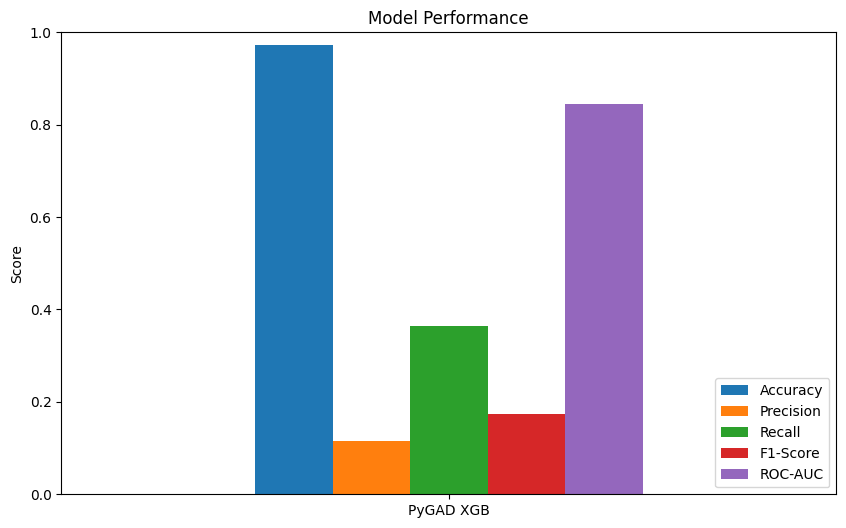

In [93]:
# Visualize Comparison
eval_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

Feature Importance

In [85]:
# Feature Importance Plotting Function
def plot_feature_importance(model, feature_names, model_name="Model", top_n=20, normalize=False):
    """
    Plots the top_n feature importances of a trained XGBoost model.

    Parameters:
    - model: Trained XGBoost model.
    - feature_names: List of feature names.
    - model_name: Name of the model (for plot title).
    - top_n: Number of top features to display.
    - normalize: Boolean indicating whether to normalize importances.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract feature importances
    importances = model.feature_importances_
    
    if normalize:
        importances = importances / importances.sum()

    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    # Select top_n features
    top_features = feature_importances[:top_n]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Normalized Importance Score' if normalize else 'Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_37328\407754748.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


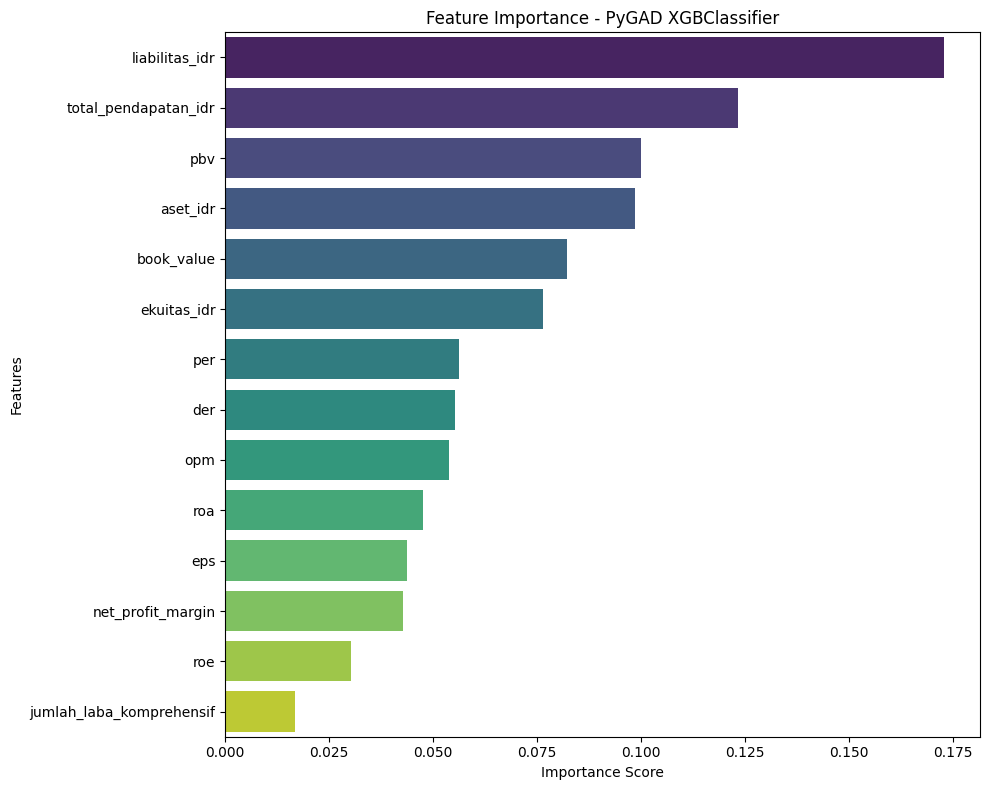

In [88]:
# Plot Feature Importance for PyGAD Best Model
plot_feature_importance(
    model=best_model_pygad,
    feature_names=X.columns,
    model_name="PyGAD XGBClassifier",
    top_n=20
)

In [90]:
import shap

def shap_feature_importance(model, X, model_name="Model"):
    """
    Plots SHAP feature importances for a trained XGBoost model.

    Parameters:
    - model: Trained XGBoost model.
    - X: Feature DataFrame used for training.
    - model_name: Name of the model (for plot title).
    """
    # Initialize SHAP Explainer
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # Summary Plot
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()

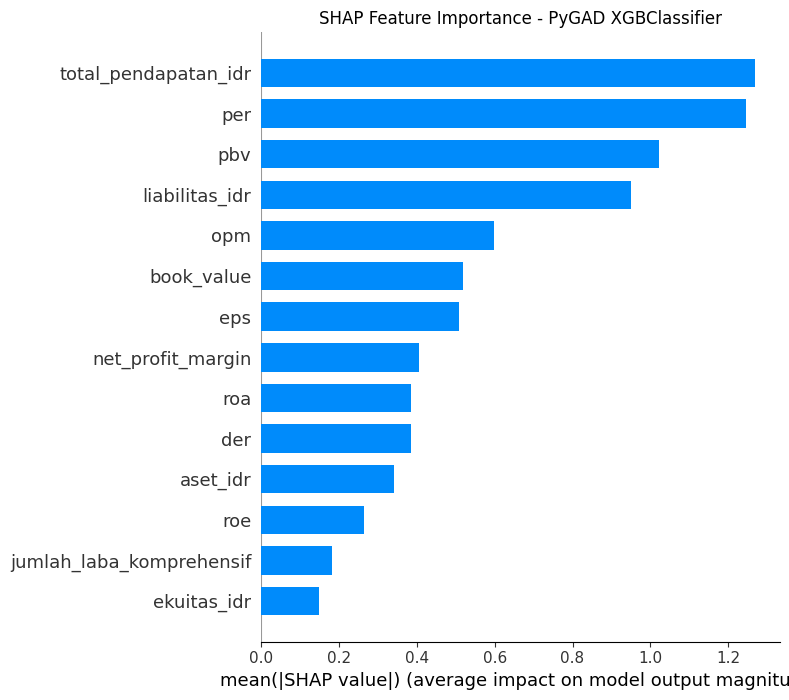

In [94]:
# SHAP Feature Importance for PyGAD Best Model
shap_feature_importance(
    model=best_model_pygad,
    X=X_test_scaled,
    model_name="PyGAD XGBClassifier"
)
